In [1]:
import numpy as np
import math
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import sys
import os
import pandas as pd
import matplotlib.patches as mpatches
%matplotlib inline

# Plot Parameters

In [2]:
# parameters
font = { 'size'   : 15}
plt.rc('font', **font)
markersize = 10 #12

# markers
colors = ['b','r','g','m','y','c']
styles = ['o','s','v','^','D',">","<","*","h","H","+","1","2","3","4","8","p","d","|","_",".",","]

# mycolor
pytorch    = '#136aa8'
tensorflow = '#ff7527'
mycolors   = [pytorch, tensorflow]

# styledict
styledict = {"thorsten": {"fontsize_annotation": 10, "roof_color": 'gray', "legend_points_ncol": 2, "frameon": False}, 
             "charlene": {"fontsize_annotation": 13, "roof_color": 'k', "legend_points_ncol": 1, "frameon": True}}

# Plot Code

In [3]:
#plot roofs
def plot_roofs(fig, ax, xlim, ylim, styledict, scaling = 1.):
    #extract general settings
    fontsize_annotation = styledict["fontsize_annotation"] #10
    roof_color = styledict["roof_color"]
    
    #set up roofs
    #mem
    smemroofs = [14*1024, 2996.77, 828.758]
    smem_roof_name = ['L1', 'L2', 'HBM']
    #smemroofs = [828.758]
    #smem_roof_name = ['HBM']
    #flops
    scomproofs_fp64 = [7669.86, 3535.79]
    #scomproofs_fp64 = [x*10**-3 for x in scomproofs_fp64]
    scomp_roof_name_fp64 = ['FMA (FP64)', 'No-FMA (FP64)']
    scomproofs_fp32 = [15158.6, 7669.1]
    scomp_roof_name_fp32 = ['FMA (FP32)', 'No-FMA (FP32)']
    scomproofs_fp16 = [106496.0] + [29181.6, 15158.6]
    scomp_roof_name_fp16 = ['Tensor Core', 'FP16', 'FP32']
    scalingFactorForRoofs = scaling
    
    #resolution
    #nx = 10000
    xmin = xlim[0]
    xmax = xlim[1]
    ymin = ylim[0]
    ymax = ylim[1]
    nx = 10*xmax
    
    #set limits
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    
    #plot roofs:
    dx = (xmax-xmin)/nx
    for idm, smem in enumerate(smemroofs):
        #fp16
        for idc, scomp in enumerate(scomproofs_fp16):
            xvals = np.arange(xmin, xmax, dx)
            yvals = np.minimum(smem*xvals, np.tile(np.array(scomp),len(xvals)))
            ax.plot(xvals, yvals, c=roof_color, ls='-', lw='2')
            if idm==0:
                #plot scomp
                label = scomp_roof_name_fp16[idc] + ': ' + '{0:.1f}'.format(float(scomp*10**-3)/scalingFactorForRoofs) + ' TFLOP/s'
                ax.annotate(label, xy=(xmax,scomp), xytext=(-5,5), textcoords="offset points", color=roof_color, horizontalalignment='right', fontsize=fontsize_annotation)
        
        #plot mem
        #find intersection
        scomp = scomproofs_fp16[0]
        yis = ymin
        xis = minimize(fun = lambda x: np.abs(min([smem*x,scomp])-yis), x0=xmin, tol=1.e-10)["x"][0]
        #find elbow
        optimize = minimize(fun=lambda x: np.abs(smem*x-scomp), x0=xmin, tol=1.e-10)
        xelb = optimize["x"][0]
        yelb = min(smem*xelb, scomp)
        #angle in plot coord system
        ang = np.rad2deg( np.arctan2(yelb-yis, xelb-xis) )
        #angle in figure coord system
        pts = np.array((xelb, yelb)).reshape((1,2))
        trans_ang = ax.transData.transform_angles(np.array((ang,)), pts)[0]
        #ax.plot(xis, yis, marker="o", ms=10)
        #ax.plot(xelb, yelb, marker="o", ms=10)
        label = smem_roof_name[idm] + ': ' + '{0:.1f}'.format(float(smem)/scalingFactorForRoofs) + ' GB/s'
        tmp_x = 0.1
        tmp_y = tmp_x * smem
        ax.annotate(label, xy=(tmp_x, tmp_y), xytext=(5,5), color=roof_color, \
                rotation=trans_ang, rotation_mode='anchor', \
                horizontalalignment='right', \
                verticalalignment='bottom', \
                textcoords="offset points", \
                fontsize=fontsize_annotation)

In [4]:
#data dependent stuff
def plot_hierarchical(tag, FLOPS, AIHBM, AIL2, AIL1, TIME):
    
    #pick style:
    style = styledict["charlene"]
    
    #figure stuff
    fig = plt.figure(1,figsize=(10.67,6.6))
    plt.clf()
    ax = fig.gca()
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Arithmetic Intensity [FLOP/Byte]')
    ax.set_ylabel('Performance [GFLOP/s]')
    xmin = -2 #np.floor(np.log(min(AI_l1))) #-2
    xmax = 3.5 #np.ceil(np.log(max(AI_dram)))
    ymin = 1 #10./scalingFactorForRoofs #10.0 / scalingFactorForRoofs
    ymax = 125000.0*5.5 #max(FLOPs)*2./scalingFactorForRoofs
    
    #some handles
    marker_handles = []
    
    #plot roofs
    plot_roofs(fig, ax, (10**xmin, 10**xmax), (ymin, ymax), style)
        
    #FP16
    for i in range(0,len(AIL1)):
        ax.plot(float(AIL1[i]),float(FLOPS[i]),c=colors[0],marker=styles[0], mfc='none', linestyle='None',ms=max(TIME[i]*260,3))
    for i in range(0,len(AIL2)):
        ax.plot(float(AIL2[i]),float(FLOPS[i]),c=colors[1],marker=styles[0], mfc='none', linestyle='None',ms=max(TIME[i]*260,3))
    for i in range(0,len(AIHBM)):
        ax.plot(float(AIHBM[i]),float(FLOPS[i]),c=colors[2],marker=styles[0], mfc='none', linestyle='dashed',ms=max(TIME[i]*260,3))
    
    #legend 2:
    patch_handles = []
    patch_handles.append(mpatches.Patch(color=colors[0],label = 'L1'))
    patch_handles.append(mpatches.Patch(color=colors[1],label = 'L2'))
    patch_handles.append(mpatches.Patch(color=colors[2],label = 'HBM'))
    leg2 = plt.legend(handles = patch_handles,loc='upper left', scatterpoints = 1, frameon=style["frameon"])
    
    #save figure
    plt.tight_layout()
    plt.savefig(tag+'.eps')

# TF: read in all the directories (fw and fwbw) into Pandas

In [5]:
datadir='../climate-seg-benchmark'
tagdirs=[x for x in os.listdir(datadir) if x.startswith('TF-') and os.path.isdir(os.path.join(datadir,x))]
tagdirs.sort()
# print(tagdirs)
dfcsfw={}

for i,tagdir in enumerate(tagdirs):
    tagd=os.path.join(datadir,tagdir)
    files=os.listdir(tagd)
    tag='-'.join(tagdir.split('-')[1:5])
#     print(tag)
        
    filess=[os.path.join(tagd,file) for file in files if 'out.fp' in file]
    print('{} files from {}'.format(len(filess),tagd))
    cntf=0
    dfmetric=pd.DataFrame()
    dfcsfw[tag]=pd.DataFrame()
    dftmp=pd.DataFrame()
    
    for file in filess:
        dft=pd.DataFrame()
        cntf+=1
        with open(file,'r') as f:
            cnt=0
            while True:
                ln=f.readline()
                if not ln:
                    break
                cnt+=1
                if 'Host Name' in ln:
                    break
            df = pd.read_csv(file, skiprows=cnt-1)
            if cntf != 1:
                newdfg=df.groupby(['Kernel Name']).sum()
                dft[df['Metric Name'][0]]=newdfg['Metric Value']
                dfmetric=pd.merge(dfmetric, dft,left_index=True,right_index=True)
            else:
                dftmp=df
                newdfg=df.groupby(['Kernel Name']).sum()
                dfmetric[df['Metric Name'][0]]=newdfg['Metric Value']
                dfmetric['Count']=df.groupby(['Kernel Name']).count()['ID']

    dfmetric['Time']=dfmetric['sm__cycles_elapsed.avg'] \
                    / (dfmetric['sm__cycles_elapsed.avg.per_second'] /dfmetric['Count'] )

    dfmetric['CC FLOPs']= 2 * dfmetric['sm__sass_thread_inst_executed_op_hfma_pred_on.sum'] \
                        + dfmetric['sm__sass_thread_inst_executed_op_hmul_pred_on.sum'] \
                        + dfmetric['sm__sass_thread_inst_executed_op_hadd_pred_on.sum'] \
                        + 2 * dfmetric['sm__sass_thread_inst_executed_op_ffma_pred_on.sum'] \
                        + dfmetric['sm__sass_thread_inst_executed_op_fmul_pred_on.sum'] \
                        + dfmetric['sm__sass_thread_inst_executed_op_fadd_pred_on.sum'] 

    dfmetric['TC FLOPs']= 512 * dfmetric['sm__inst_executed_pipe_tensor.sum']
    dfmetric['all FLOPs']= dfmetric['CC FLOPs'] + dfmetric['TC FLOPs']

    dfmetric['AI HBM'] = dfmetric['all FLOPs'].div(dfmetric['dram__bytes.sum'])
    dfmetric['AI L2'] = dfmetric['all FLOPs'].div(dfmetric['lts__t_bytes.sum'])
    dfmetric['AI L1'] = dfmetric['all FLOPs'].div(dfmetric['l1tex__t_bytes.sum'])

    dfmetric['GFLOP/s'] = dfmetric['all FLOPs']/ dfmetric['Time'] /1024/1024/1024
    dfmetric['TC GFLOP/s'] = dfmetric['TC FLOPs']/ dfmetric['Time'] /1024/1024/1024

#     dfmetric.to_csv(tag+'.csv')

    dfcsfw[tag]=pd.concat([dfcsfw[tag],dfmetric])
    print('\twith shape {}: {:4d} kernels (grouped by name) and {:3d} metrics (both raw and derived)'.format(dfcsfw[tag].shape,\
                                                                                     dfcsfw[tag].shape[0],\
                                                                                     dfcsfw[tag].shape[1]))
    
print('--------------')
print('All {} directories (fw and fwbw) have been read in to dfcsfw with tags: \n{}'\
      .format(len(list(dfcsfw.keys())),list(dfcsfw.keys())))

12 files from ../climate-seg-benchmark/TF-fp16-batch2-fw-amp-732365
	with shape (49, 22):   49 kernels (grouped by name) and  22 metrics (both raw and derived)
12 files from ../climate-seg-benchmark/TF-fp16-batch2-fw-noamp-732366
	with shape (49, 22):   49 kernels (grouped by name) and  22 metrics (both raw and derived)
12 files from ../climate-seg-benchmark/TF-fp16-batch2-fwbw-amp-732367
	with shape (107, 22):  107 kernels (grouped by name) and  22 metrics (both raw and derived)
12 files from ../climate-seg-benchmark/TF-fp16-batch2-fwbw-noamp-732368
	with shape (101, 22):  101 kernels (grouped by name) and  22 metrics (both raw and derived)
12 files from ../climate-seg-benchmark/TF-fp32-batch1-fw-amp-732369
	with shape (54, 22):   54 kernels (grouped by name) and  22 metrics (both raw and derived)
12 files from ../climate-seg-benchmark/TF-fp32-batch1-fw-noamp-732370
	with shape (36, 22):   36 kernels (grouped by name) and  22 metrics (both raw and derived)
12 files from ../climate-seg

# Subtract fw from fwbw to get bw 

In [6]:
datadir='/global/cfs/cdirs/dasrepo/yswang/DeepLearningProfiling/climate-seg-benchmark'
metrics=['sm__sass_thread_inst_executed_op_hfma_pred_on.sum', \
       'sm__sass_thread_inst_executed_op_hmul_pred_on.sum', \
       'sm__sass_thread_inst_executed_op_ffma_pred_on.sum', \
       'sm__sass_thread_inst_executed_op_fmul_pred_on.sum', \
       'sm__sass_thread_inst_executed_op_fadd_pred_on.sum', \
       'sm__sass_thread_inst_executed_op_hadd_pred_on.sum', \
       'sm__inst_executed_pipe_tensor.sum', \
       'sm__cycles_elapsed.avg.per_second', 'sm__cycles_elapsed.avg', \
       'dram__bytes.sum', 'lts__t_bytes.sum', 'l1tex__t_bytes.sum']

tagsold=list(dfcsfw.keys())
tagstmp=[x.replace('-fwbw','') for x in tagsold]
tagsnew=set([x.replace('-fw','') for x in tagstmp])
tags=[('-'.join(x.split('-')[0:2]),'-'+x.split('-')[2]) for x in tagsnew]
# print(tags)

dfcsbw={}
for tag in tags:
    
    tagdirs=[x for x in os.listdir(datadir) if x.startswith('TF-') and os.path.isdir(os.path.join(datadir,x)) \
             and tag[0] in x and tag[1] in x]
    tagdirs.sort()
#     print(tagdirs)

    dfmetric=pd.DataFrame()
    flag=True
    for metric in metrics: 
        dffw=pd.DataFrame()
        dffwbw=pd.DataFrame()
        for tagdir in tagdirs:
            tagd=os.path.join(datadir,tagdir)
            files=os.listdir(tagd)    
            filess=[os.path.join(tagd,fl) for fl in files if 'out.fp' in fl and fl.endswith(metric)]
            file=filess[0]

            with open(file,'r') as f:
                cnt=0
                while True:
                    ln=f.readline()
                    if not ln:
                        break
                    cnt+=1
                    if 'Host Name' in ln:
                        break
                df = pd.read_csv(file, skiprows=cnt-1)
                if '-fw-' in file:
                    dffw=df
                else:
                    dffwbw=df
        dff=dffw.groupby('Kernel Name').count()['ID']
        dffbcnt=dffwbw.groupby('Kernel Name').count()['ID']
        dffb=dffwbw.groupby(['Kernel Name','ID']).sum()
        dffb=dffb.reset_index('ID')
        dfb=pd.DataFrame()
        cnt=0
        for i in range(dffbcnt.shape[0]):
            if dffbcnt.index.to_list()[i] in dff.index.to_list():
                cnt=cnt+1
                diff=dffbcnt.iloc[i]-dff.loc[dffbcnt.index.to_list()[i]]
                if diff >0:
                    dfb=pd.concat([dfb,dffb.loc[dffbcnt.index.to_list()[i]][-diff:]['Metric Value']])
            else:
                if dffb[dffb.index==dffbcnt.index.to_list()[i]].shape[0]>0:
                    dfb=pd.concat([dfb,dffb[dffb.index==dffbcnt.index.to_list()[i]]['Metric Value']])

        dfb=dfb.reset_index()
        dfb.columns=['Kernel Name',metric]
#         print(metric)
        if flag:
            dfmetric['Count']=dfb.groupby(['Kernel Name']).count()[metric]
            flag=False
        dfmetric[metric]=dfb.groupby(['Kernel Name']).sum()[metric]
    
    
    dfmetric['Time']=dfmetric['sm__cycles_elapsed.avg'] \
                    / (dfmetric['sm__cycles_elapsed.avg.per_second'] /dfmetric['Count'] )

    dfmetric['CC FLOPs']= 2 * dfmetric['sm__sass_thread_inst_executed_op_hfma_pred_on.sum'] \
                        + dfmetric['sm__sass_thread_inst_executed_op_hmul_pred_on.sum'] \
                        + dfmetric['sm__sass_thread_inst_executed_op_hadd_pred_on.sum'] \
                        + 2 * dfmetric['sm__sass_thread_inst_executed_op_ffma_pred_on.sum'] \
                        + dfmetric['sm__sass_thread_inst_executed_op_fmul_pred_on.sum'] \
                        + dfmetric['sm__sass_thread_inst_executed_op_fadd_pred_on.sum'] 

    dfmetric['TC FLOPs']= 512 * dfmetric['sm__inst_executed_pipe_tensor.sum']

    dfmetric['all FLOPs']= dfmetric['CC FLOPs'] + dfmetric['TC FLOPs']

    dfmetric['AI HBM'] = dfmetric['all FLOPs'].div(dfmetric['dram__bytes.sum'])
    dfmetric['AI L2'] = dfmetric['all FLOPs'].div(dfmetric['lts__t_bytes.sum'])
    dfmetric['AI L1'] = dfmetric['all FLOPs'].div(dfmetric['l1tex__t_bytes.sum'])

    dfmetric['GFLOP/s'] = dfmetric['all FLOPs']/ dfmetric['Time'] /1024/1024/1024
    dfmetric['TC GFLOP/s'] = dfmetric['TC FLOPs']/ dfmetric['Time'] /1024/1024/1024

    newtag=tag[0]+'-bw'+tag[1]
    
#     dfmetric.to_csv(newtag+'.csv')
    
    dfcsbw[newtag]=dfmetric
    print('{} is complete with shape {}'.format(newtag,dfcsbw[newtag].shape))
    
print('--------------')
print('All {} dataframes (bw) have been extracted, with tags: \n{}'\
      .format(len(list(dfcsbw.keys())),list(dfcsbw.keys())))

fp32-batch1-bw-noamp is complete with shape (56, 22)
fp16-batch2-bw-noamp is complete with shape (72, 22)
fp32-batch1-bw-amp is complete with shape (81, 22)
fp16-batch2-bw-amp is complete with shape (78, 22)
fp32-batch2-bw-amp is complete with shape (79, 22)
--------------
All 5 dataframes (bw) have been extracted, with tags: 
['fp32-batch1-bw-noamp', 'fp16-batch2-bw-noamp', 'fp32-batch1-bw-amp', 'fp16-batch2-bw-amp', 'fp32-batch2-bw-amp']


In [7]:
# show all fw tags
tags=dfcsfw.keys()
print(tags)

dict_keys(['fp16-batch2-fw-amp', 'fp16-batch2-fw-noamp', 'fp16-batch2-fwbw-amp', 'fp16-batch2-fwbw-noamp', 'fp32-batch1-fw-amp', 'fp32-batch1-fw-noamp', 'fp32-batch1-fwbw-amp', 'fp32-batch1-fwbw-noamp', 'fp32-batch2-fw-amp', 'fp32-batch2-fwbw-amp'])


## TF FW hierarchical batch2 FP32+AMP

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


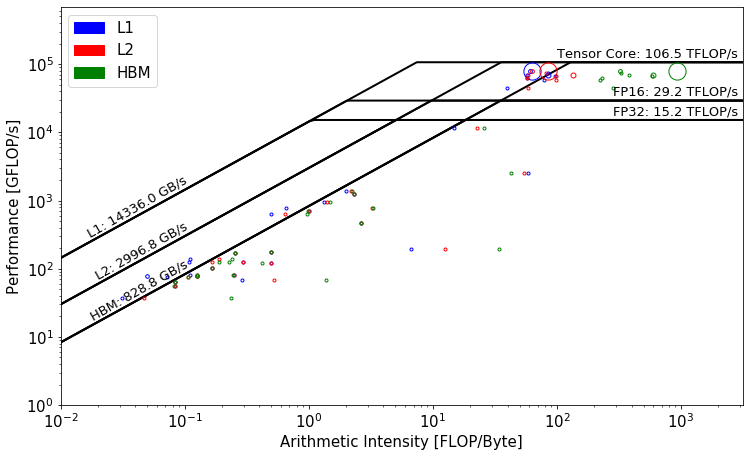

In [8]:
tag='fp32-batch2-fw-amp'
dfm=dfcsfw[tag]
dfm = dfm.sort_values('Time', ascending=False).reset_index(drop=True)
#dfm = dfm.head(10)
#display(dfm)

LABELS = []
AIL1   = dfm['AI L1'].tolist()
AIL2   = dfm['AI L2'].tolist()
AIHBM  = dfm['AI HBM'].tolist()
FLOPS  = dfm['GFLOP/s'].tolist()
TCFLOPS  = dfm['TC GFLOP/s'].tolist()
COUNT  = dfm['Count'].tolist()
TIME   = dfm['Time'].tolist()

plot_hierarchical(tag, FLOPS, AIHBM, AIL2, AIL1, TIME)

## TF BW hierarchical batch2 FP32+AMP

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


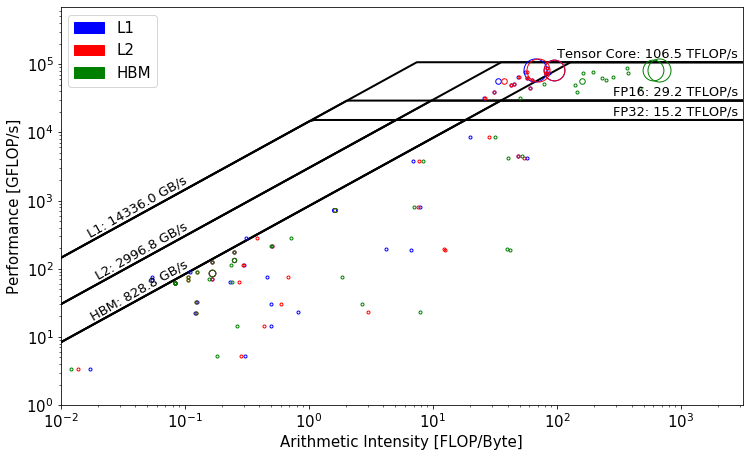

In [9]:
tag='fp32-batch2-bw-amp'
dfm=dfcsbw[tag]
dfm = dfm.sort_values('Time', ascending=False).reset_index(drop=True)
#dfm = dfm.head(10)
#display(dfm)

LABELS = []
AIL1   = dfm['AI L1'].tolist()
AIL2   = dfm['AI L2'].tolist()
AIHBM  = dfm['AI HBM'].tolist()
FLOPS  = dfm['GFLOP/s'].tolist()
TCFLOPS  = dfm['TC GFLOP/s'].tolist()
COUNT  = dfm['Count'].tolist()
TIME   = dfm['Time'].tolist()

plot_hierarchical(tag, FLOPS, AIHBM, AIL2, AIL1, TIME)

## TF BW hierarchical batch2 FP16

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


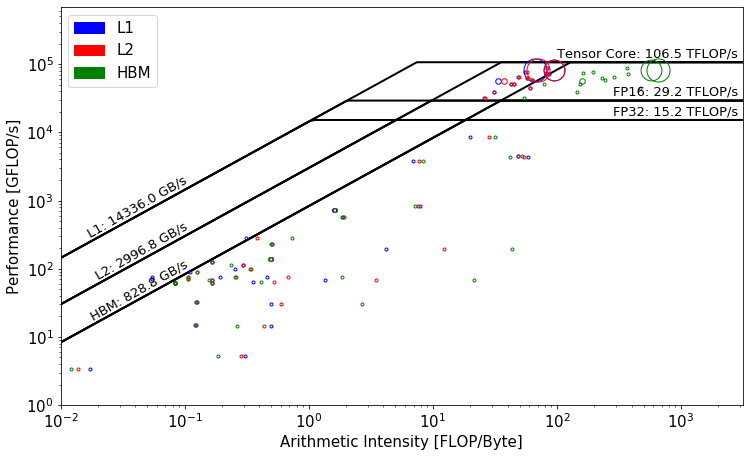

In [10]:
tag='fp16-batch2-bw-noamp'
dfm=dfcsbw[tag]
dfm = dfm.sort_values('Time', ascending=False).reset_index(drop=True)
#dfm = dfm.head(10)
#display(dfm)

LABELS = []
AIL1   = dfm['AI L1'].tolist()
AIL2   = dfm['AI L2'].tolist()
AIHBM  = dfm['AI HBM'].tolist()
FLOPS  = dfm['GFLOP/s'].tolist()
TCFLOPS  = dfm['TC GFLOP/s'].tolist()
COUNT  = dfm['Count'].tolist()
TIME   = dfm['Time'].tolist()

plot_hierarchical(tag, FLOPS, AIHBM, AIL2, AIL1, TIME)

# PT: read data into Pandas

In [11]:
datadir='../mlperf-deepcam'
tagdirs=[x for x in os.listdir(datadir) if x.startswith('PT-fp')]
tagdirs.sort()
# print(tagdirs)
dfcs={}

for i,tagdir in enumerate(tagdirs):
    tagd=os.path.join(datadir,tagdir)
    files=os.listdir(tagd)
    tag='-'.join(tagdir.split('-')[1:5])
#     print(tag)
    
    filess=[os.path.join(tagd,file) for file in files if 'out.' in file]
    print('{} files from {}'.format(len(filess),tagd))
    cntf=0
    dfmetric=pd.DataFrame()
    dfcs[tag]=pd.DataFrame()
    dftmp=pd.DataFrame()
    
    
    for file in filess:
        dft=pd.DataFrame()
        cntf+=1
        with open(file,'r') as f:
            cnt=0
            while True:
                ln=f.readline()
                if not ln:
                    break
                cnt+=1
                if 'Host Name' in ln:
                    break
            df = pd.read_csv(file, skiprows=cnt-1)
            if cntf != 1:
                newdfg=df.groupby(['Kernel Name']).sum()
                dft[df['Metric Name'][0]]=newdfg['Metric Value']
                dfmetric=pd.merge(dfmetric, dft,left_index=True,right_index=True)
            else:
                dftmp=df
                newdfg=df.groupby(['Kernel Name']).sum()
                dfmetric[df['Metric Name'][0]]=newdfg['Metric Value']
                dfmetric['Count']=df.groupby(['Kernel Name']).count()['ID']

    dfmetric['Time']=dfmetric['sm__cycles_elapsed.avg'] \
                    / (dfmetric['sm__cycles_elapsed.avg.per_second'] /dfmetric['Count'] )

    dfmetric['CC FLOPs']= 2 * dfmetric['sm__sass_thread_inst_executed_op_hfma_pred_on.sum'] \
                        + dfmetric['sm__sass_thread_inst_executed_op_hmul_pred_on.sum'] \
                        + dfmetric['sm__sass_thread_inst_executed_op_hadd_pred_on.sum'] \
                        + 2 * dfmetric['sm__sass_thread_inst_executed_op_ffma_pred_on.sum'] \
                        + dfmetric['sm__sass_thread_inst_executed_op_fmul_pred_on.sum'] \
                        + dfmetric['sm__sass_thread_inst_executed_op_fadd_pred_on.sum'] 

    dfmetric['TC FLOPs']= 512 * dfmetric['sm__inst_executed_pipe_tensor.sum']

    dfmetric['all FLOPs']= dfmetric['CC FLOPs'] + dfmetric['TC FLOPs']

    dfmetric['AI HBM'] = dfmetric['all FLOPs'].div(dfmetric['dram__bytes.sum'])
    dfmetric['AI L2'] = dfmetric['all FLOPs'].div(dfmetric['lts__t_bytes.sum'])
    dfmetric['AI L1'] = dfmetric['all FLOPs'].div(dfmetric['l1tex__t_bytes.sum'])

    dfmetric['GFLOP/s'] = dfmetric['all FLOPs']/ dfmetric['Time'] /1024/1024/1024
    dfmetric['TC GFLOP/s'] = dfmetric['TC FLOPs']/ dfmetric['Time'] /1024/1024/1024

#     dfmetric.to_csv(tag+'.csv')

    dfcs[tag]=pd.concat([dfcs[tag],dfmetric])
    print('\twith shape {}: {:4d} kernels (grouped by name) \
and {:3d} metrics (both raw and derived)'.format(dfcs[tag].shape,\
                                                 dfcs[tag].shape[0],
                                                 dfcs[tag].shape[1]))
    
print('--------------')
print('All {} directories (fw, bw and opt) have been read in to dfcs with tags: \n{}'\
      .format(len(list(dfcs.keys())),list(dfcs.keys())))

12 files from ../mlperf-deepcam/PT-fp32-O0-Adam-bw-732898
	with shape (54, 22):   54 kernels (grouped by name) and  22 metrics (both raw and derived)
12 files from ../mlperf-deepcam/PT-fp32-O0-Adam-fw-733726
	with shape (35, 22):   35 kernels (grouped by name) and  22 metrics (both raw and derived)
12 files from ../mlperf-deepcam/PT-fp32-O0-Adam-opt-732900
	with shape (7, 22):    7 kernels (grouped by name) and  22 metrics (both raw and derived)
12 files from ../mlperf-deepcam/PT-fp32-O1-Adam-bw-733727
	with shape (70, 22):   70 kernels (grouped by name) and  22 metrics (both raw and derived)
12 files from ../mlperf-deepcam/PT-fp32-O1-Adam-fw-733728
	with shape (45, 22):   45 kernels (grouped by name) and  22 metrics (both raw and derived)
12 files from ../mlperf-deepcam/PT-fp32-O1-Adam-opt-733729
	with shape (7, 22):    7 kernels (grouped by name) and  22 metrics (both raw and derived)
12 files from ../mlperf-deepcam/PT-fp32-O1-AdamW-bw-733730
	with shape (70, 22):   70 kernels (group

## PT FW hierarchical batch2 FP32+AMPO1

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


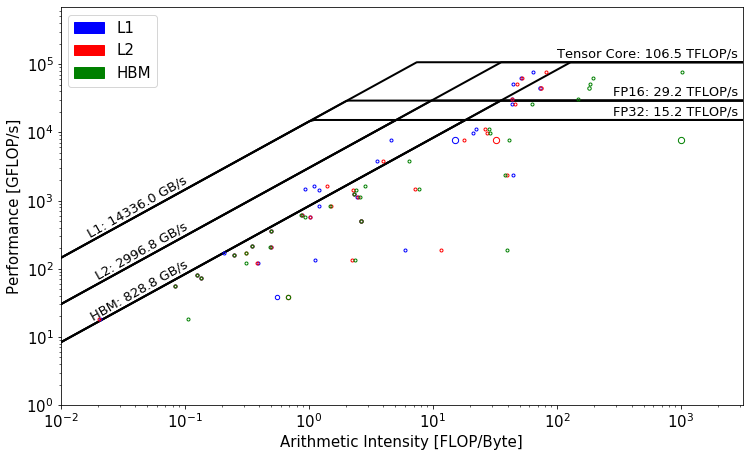

In [12]:
tag='fp32-O1-Adam-fw'
dfm=dfcs[tag]
dfm = dfm.sort_values('Time', ascending=False).reset_index(drop=True)
#dfm = dfm.head(10)
#display(dfm)

LABELS = []
AIL1   = dfm['AI L1'].tolist()
AIL2   = dfm['AI L2'].tolist()
AIHBM  = dfm['AI HBM'].tolist()
FLOPS  = dfm['GFLOP/s'].tolist()
TCFLOPS  = dfm['TC GFLOP/s'].tolist()
COUNT  = dfm['Count'].tolist()
TIME   = dfm['Time'].tolist()

plot_hierarchical(tag, FLOPS, AIHBM, AIL2, AIL1, TIME)

## PT BW hierarchical batch2 FP32+AMPO1

0.22833683424208875


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


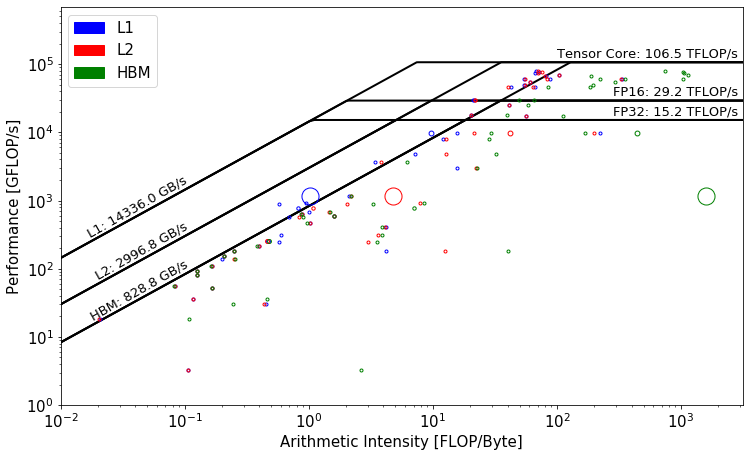

In [13]:
tag='fp32-O1-Adam-bw'
dfm=dfcs[tag]
dfm = dfm.sort_values('Time', ascending=False).reset_index(drop=True)
#dfm = dfm.head(10)
#display(dfm)

LABELS = []
AIL1   = dfm['AI L1'].tolist()
AIL2   = dfm['AI L2'].tolist()
AIHBM  = dfm['AI HBM'].tolist()
FLOPS  = dfm['GFLOP/s'].tolist()
TCFLOPS  = dfm['TC GFLOP/s'].tolist()
COUNT  = dfm['Count'].tolist()
TIME   = dfm['Time'].tolist()

print(sum(TIME))

plot_hierarchical(tag, FLOPS, AIHBM, AIL2, AIL1, TIME)

## PT OPT hierarchical batch2 FP32+AMPO1

2709
30.724289110951435
352.53110723385515


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


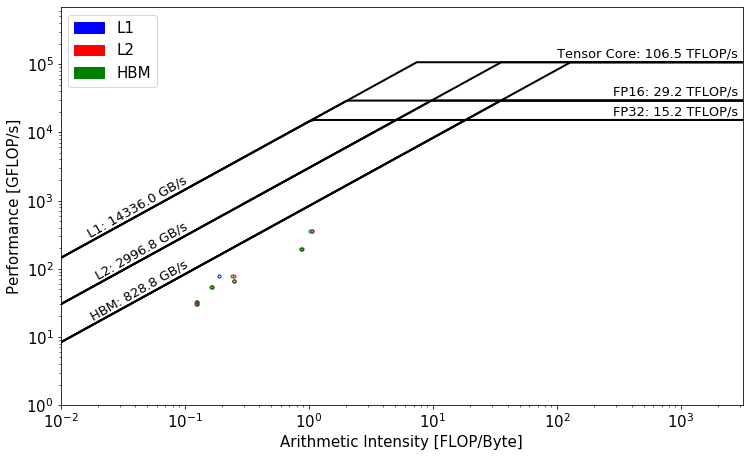

In [14]:
tag='fp32-O1-Adam-opt'
dfm=dfcs[tag]
dfm = dfm.sort_values('Time', ascending=False).reset_index(drop=True)
#dfm = dfm.head(10)
#display(dfm)

LABELS = []
AIL1   = dfm['AI L1'].tolist()
AIL2   = dfm['AI L2'].tolist()
AIHBM  = dfm['AI HBM'].tolist()
FLOPS  = dfm['GFLOP/s'].tolist()
TCFLOPS  = dfm['TC GFLOP/s'].tolist()
COUNT  = dfm['Count'].tolist()
TIME   = dfm['Time'].tolist()

print(sum(COUNT))
print(min(FLOPS))
print(max(FLOPS))

plot_hierarchical(tag, FLOPS, AIHBM, AIL2, AIL1, TIME)

## PT BW hierarchical batch2 FP32+AMPO2

0.22964719392376076


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


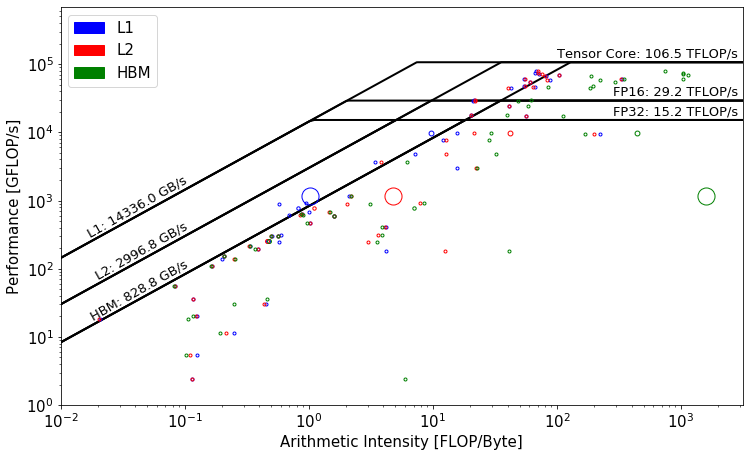

In [15]:
tag='fp32-O2-Adam-bw'
dfm=dfcs[tag]
dfm = dfm.sort_values('Time', ascending=False).reset_index(drop=True)
#dfm = dfm.head(10)
#display(dfm)

LABELS = []
AIL1   = dfm['AI L1'].tolist()
AIL2   = dfm['AI L2'].tolist()
AIHBM  = dfm['AI HBM'].tolist()
FLOPS  = dfm['GFLOP/s'].tolist()
TCFLOPS  = dfm['TC GFLOP/s'].tolist()
COUNT  = dfm['Count'].tolist()
TIME   = dfm['Time'].tolist()

print(sum(TIME))

plot_hierarchical(tag, FLOPS, AIHBM, AIL2, AIL1, TIME)

## PT BW hierarchical batch2 FP32+AMPO0

0.400614910284275


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


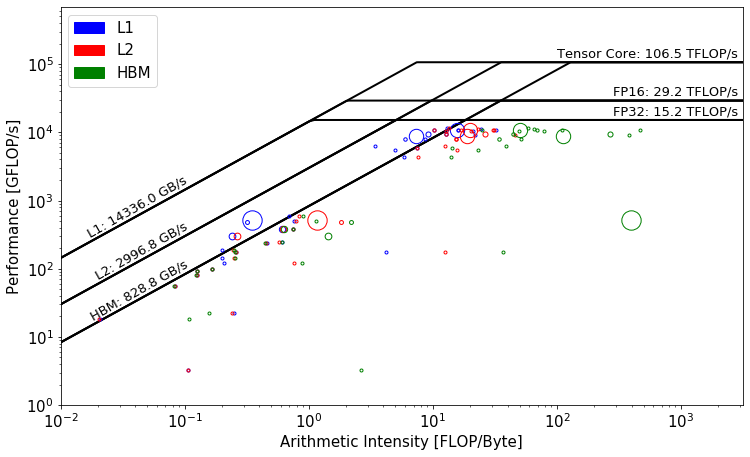

In [16]:
tag='fp32-O0-Adam-bw'
dfm=dfcs[tag]
dfm = dfm.sort_values('Time', ascending=False).reset_index(drop=True)
#dfm = dfm.head(10)
#display(dfm)

LABELS = []
AIL1   = dfm['AI L1'].tolist()
AIL2   = dfm['AI L2'].tolist()
AIHBM  = dfm['AI HBM'].tolist()
FLOPS  = dfm['GFLOP/s'].tolist()
TCFLOPS  = dfm['TC GFLOP/s'].tolist()
COUNT  = dfm['Count'].tolist()
TIME   = dfm['Time'].tolist()

print(sum(TIME))

plot_hierarchical(tag, FLOPS, AIHBM, AIL2, AIL1, TIME)